In [1]:
import io
import re
import string
import tqdm
import os
import numpy as np
import string
from nltk.corpus import stopwords
from nltk import Text

from music21 import *

np.random.seed(42)

In [2]:
def transpose_notes(notes):
    midi_stream = stream.Stream(notes)
    ori_key = midi_stream.analyze('key')
    k_interval = interval.Interval(ori_key.tonic, key.Key('C').tonic)
    new_stream = midi_stream.transpose(k_interval)
    return new_stream

def softmax(vec):
    return np.exp(vec) / np.exp(vec).sum()

In [3]:
file_list = os.listdir(r"./scores/bach")
mxl_file_list = [file for file in file_list if '.mxl' in file]

bach_list = []

for mxl_file in mxl_file_list:
    bach = corpus.parse(f'bach/{mxl_file}')
    if 'major' in str(bach.analyze('key')):
        sb = bach.getElementsByClass('Part')
        for part in sb:
            if 'Soprano' in str(part):
                sp_ind = [str(soprano) for soprano in sb].index(str(part))
                sp = sb[sp_ind]
                tn = transpose_notes(sp)
                note_list = [(str(notes.pitches)[22:-3],notes.beat) for notes in tn.recurse().notes if 'music' not in str(notes.pitches)[22:-3]]
                bach_list.append(note_list)

In [4]:
note_vertex, index = {}, 0  # start indexing from 1
for i in range(len(bach_list)):
    for bach_note in bach_list[i]:
        if bach_note not in note_vertex:
            note_vertex[bach_note] = index
            index += 1
vertex_size = len(note_vertex)

In [5]:
bach_list_total = []
for i in range(len(bach_list)):
    for j in range(len(bach_list[i])):
        bach_list_total.append(bach_list[i][j])
len(bach_list_total)

11516

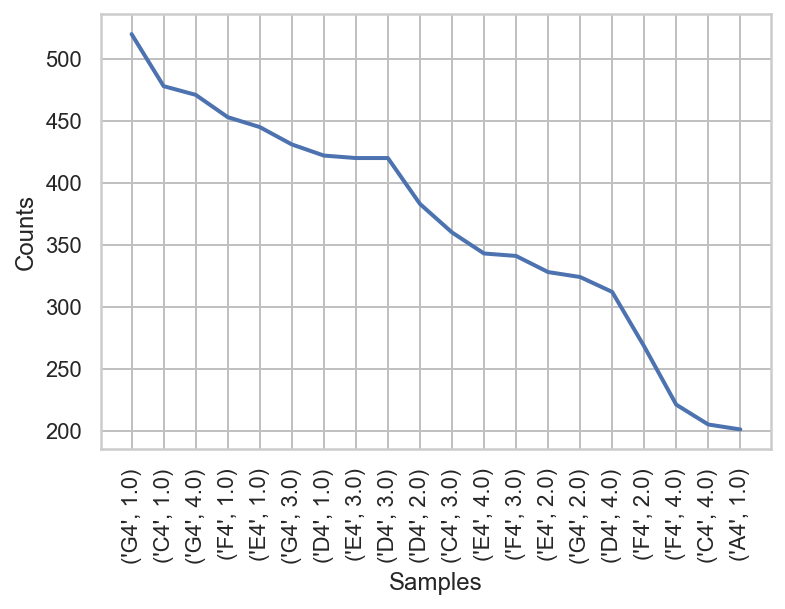

In [6]:
text = Text(bach_list_total)
text.plot(20)
plt.show()

In [7]:
str_note_vertex = [str(note_v) for note_v in note_vertex]
df = pd.DataFrame(0, index=str_note_vertex, columns=str_note_vertex)
for i in range(len(bach_list)):
    for j in range(len(bach_list[i])-1):
        df.loc[str(bach_list[i][j]),str(bach_list[i][j+1])] += 1
df = df.sort_index()
df = df.reindex(sorted(df.columns), axis=1)
df

,"('A-3', 1.0)","('A-3', 2.0)","('A-3', 2.5)","('A-3', 3.0)","('A-3', 3.5)","('A-3', 4.0)","('A-3', 4.5)","('A-4', 1.0)","('A-4', 1.5)","('A-4', 2.0)","('A-4', 2.5)","('A-4', 3.0)","('A-4', 3.5)","('A-4', 3.75)","('A-4', 4.0)","('A-4', 4.5)","('A-4', Fraction(5, 3))","('A-4', Fraction(8, 3))","('A-5', 1.0)","('A3', 1.0)","('A3', 1.5)","('A3', 2.0)","('A3', 2.5)","('A3', 3.0)","('A3', 3.5)","('A3', 4.0)","('A3', 4.5)","('A4', 1.0)","('A4', 1.5)","('A4', 1.75)","('A4', 2.0)","('A4', 2.5)","('A4', 2.75)","('A4', 3.0)","('A4', 3.5)","('A4', 4.0)","('A4', 4.25)","('A4', 4.5)","('A4', 4.75)","('A5', 1.0)","('A5', 3.0)","('B-3', 1.0)","('B-3', 1.5)","('B-3', 2.0)","('B-3', 2.5)","('B-3', 3.0)","('B-3', 4.0)","('B-3', 4.5)","('B-4', 1.0)","('B-4', 1.5)","('B-4', 1.75)","('B-4', 2.0)","('B-4', 2.5)","('B-4', 2.75)","('B-4', 3.0)","('B-4', 3.75)","('B-4', 4.0)","('B-4', 4.5)","('B-4', 4.75)","('B-4', Fraction(8, 3))",...,"('F3', 1.0)","('F3', 2.0)","('F3', 3.0)","('F3', 4.0)","('F4', 1.0)","('F4', 1.5)","('F4', 1.75)","('F4', 2.0)","('F4', 2.5)","('F4', 2.75)","('F4', 3.0)","('F4', 3.5)","('F4', 3.75)","('F4', 3.875)","('F4', 4.0)","('F4', 4.5)","('F4', 4.75)","('F5', 1.0)","('F5', 1.5)","('F5', 2.0)","('F5', 2.5)","('F5', 3.0)","('F5', 3.5)","('F5', 3.75)","('F5', 4.0)","('F5', 4.5)","('F5', 4.75)","('G#4', 1.0)","('G#4', 2.0)","('G#4', 3.0)","('G#4', 4.0)","('G3', 1.0)","('G3', 1.5)","('G3', 2.0)","('G3', 2.5)","('G3', 3.0)","('G3', 3.5)","('G3', 4.0)","('G3', 4.5)","('G4', 1.0)","('G4', 1.5)","('G4', 1.75)","('G4', 2.0)","('G4', 2.5)","('G4', 2.75)","('G4', 3.0)","('G4', 3.5)","('G4', 3.75)","('G4', 4.0)","('G4', 4.5)","('G4', 4.75)","('G4', Fraction(11, 3))","('G5', 1.0)","('G5', 1.5)","('G5', 1.75)","('G5', 2.0)","('G5', 2.5)","('G5', 3.0)","('G5', 3.75)","('G5', 4.0)"
"('A-3', 1.0)",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"('A-3', 2.0)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"('A-3', 2.5)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"('A-3', 3.0)",0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"('A-3', 3.5)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"('G5', 2.0)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"('G5', 2.5)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,

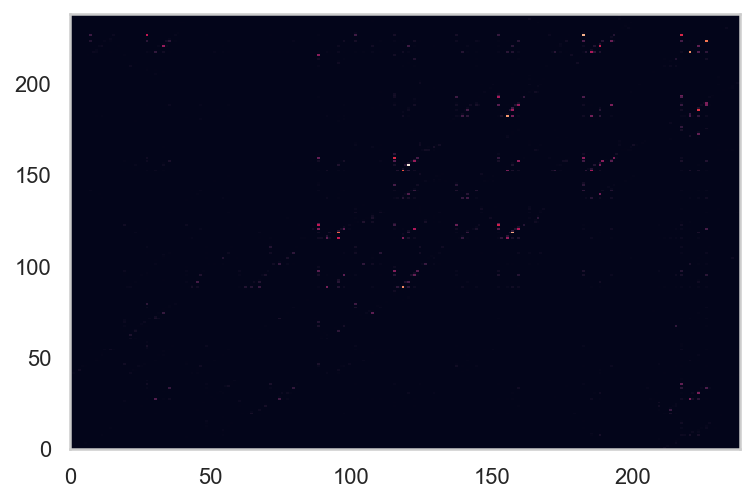

In [8]:
plt.pcolor(df)

In [234]:
class Skipgram:
    X_train = []
    y_train = []
    
    def __init__(self, d, window_size, alpha, epochs):
        self.d = d    # dimension of embedding vector
        self.window_size = window_size    # window_size
        self.alpha = alpha    # learning rate
        self.epochs = epochs
        
    def preprocessing(self, sentences):
        self.words = {}    # 모든 단어 dict
        # sentence : 1개의 곡(선율)
        for sentence in sentences:
            # word : 1개의 음표
            for word in sentence:
                if word not in self.words:
                    self.words[word] = 1
                else:
                    self.words[word] += 1

        self.n = len(self.words)   # n : 모든 단어(음표)의 수
        self.words = sorted(list(self.words.keys()))
        self.word_dict = {word : i for i,word in enumerate(self.words)}

        for sentence in sentences:
            for i in range(len(sentence)):
                # 원핫인코딩
                center_word = np.zeros(self.n)
                center_word[self.word_dict[sentence[i]]] = 1
                context = np.zeros(self.n)
                for j in range(max(0, i-self.window_size), min(len(sentence)-1, i+self.window_size)):
                    context[self.word_dict[sentence[j]]] += 1
                self.X_train.append(center_word)
                self.y_train.append(context)
        
    def feedforward(self, X):
        self.h = np.dot(self.W1.T,X)
        self.u = np.dot(self.W2.T,self.h)
        self.y = softmax(self.u)
        return self.y
    
    def backpropagate(self,x,t):
        error_mat = np.zeros((int(t.sum()), self.n))
        for i, context_note in enumerate(np.where(t)[0]):
            y_true = np.zeros(self.n)
            y_true[context_note] = 1
            error = self.y - y_true
            error_mat[i] = error.T
        dedw2 = np.zeros(self.W2.shape)
        ei = error_mat.sum(axis=0)
        for i in range(self.d):
            for j in range(self.n):
                dedw2[i][j] = ei[j] * self.h[i]
        eh = ei*self.W2
        self.W2 -= self.alpha*dedw2
        self.W1 -= self.alpha*eh.T
        
    def fit(self, sentences):
        self.preprocessing(sentences)
        self.W1 = np.random.uniform(-0.8, 0.8, (self.n, self.d))
        self.W2 = np.random.uniform(-0.8, 0.8, (self.d, self.n))
        self.prevloss = int(1e9)
        for epoch in range(self.epochs):
            self.loss = 0
            for j in range(len(self.X_train)):
                self.feedforward(self.X_train[j])
                self.backpropagate(self.X_train[j],self.y_train[j])
                for m in np.where(self.y_train[j])[0]:
                    self.loss += -1*self.u[m]
                self.loss += int(self.y_train[j].sum())*np.log(np.sum(np.exp(self.u)))
            print("epoch ", epoch+1, " loss = ",self.loss)
            if self.loss > self.prevloss:
                print("Callback executed")
                break
            self.alpha *= 1/(1+self.alpha*epoch)
        
    def predict(self,word,number_of_predictions):
        if word in self.words:
            index = self.word_dict[word]
            X = [0 for i in range(self.n)]
            X[index] = 1
            prediction = self.feedforward(X)
            output = {}
            for i in range(self.n):
                output[prediction[i]] = i

            top_context_words = []
            for k in sorted(output,reverse=True):
                top_context_words.append(self.words[output[k]])
                if(len(top_context_words)>=number_of_predictions):
                    break

            return top_context_words
        else:
            print("Word not found in dictionary")

In [235]:
sg = Skipgram(4, 2, 0.0001, 70)
sg.fit(bach_list)

epoch  1  loss =  247715.90250356554
epoch  2  loss =  246803.18470053878
epoch  3  loss =  245972.1252961166
epoch  4  loss =  245197.61920711133
epoch  5  loss =  244456.9446434921
epoch  6  loss =  243729.57300010585
epoch  7  loss =  242997.93406963852
epoch  8  loss =  242249.6457678251
epoch  9  loss =  241481.33116643777
epoch  10  loss =  240701.93678778142
epoch  11  loss =  239929.3548378509
epoch  12  loss =  239176.9027610357
epoch  13  loss =  238443.6548756467
epoch  14  loss =  237722.8088703404
epoch  15  loss =  237013.37021402208
epoch  16  loss =  236319.464482586
epoch  17  loss =  235641.78572542948
epoch  18  loss =  234972.20516916085
epoch  19  loss =  234295.71480848663
epoch  20  loss =  233593.95530566474
epoch  21  loss =  232846.532452991
epoch  22  loss =  232034.04883412056
epoch  23  loss =  231144.4573907696
epoch  24  loss =  230176.71900337085
epoch  25  loss =  229138.45750415337
epoch  26  loss =  228041.5809812458
epoch  27  loss =  226899.97911660

In [236]:
print(sg.predict(('C4', 1.0),10))
print(sg.predict(('D4', 2.0),10)) #1
print(sg.predict(('E4', 3.0),10)) #1
print(sg.predict(('G4', 4.0),10)) #1

print(sg.predict(('F4', 1.0),10)) #1
print(sg.predict(('E4', 3.0),10)) #1
print(sg.predict(('G4', 4.0),10)) #1

print(sg.predict(('F4', 1.0),10)) #1
print(sg.predict(('E4', 2.0),10)) #3
print(sg.predict(('D4', 3.0),10)) #1
print(sg.predict(('G4', 4.0),10)) #3

print(sg.predict(('G4', 1.0),10)) #2

[('C4', 1.0), ('G3', 4.0), ('E4', 3.0), ('B3', 3.0), ('C4', 2.0), ('D4', 4.0), ('B-3', 3.0), ('D4', 2.0), ('B-3', 4.0), ('E4', 1.5)]
[('D4', 2.0), ('C4', 1.0), ('D4', 4.0), ('E4', 3.0), ('C4', 3.0), ('G3', 4.0), ('D4', 1.0), ('C4', 2.0), ('E-4', 2.0), ('B3', 3.0)]
[('E4', 3.0), ('C4', 1.0), ('D4', 2.0), ('D4', 4.0), ('E4', 1.0), ('F4', 1.0), ('D4', 3.0), ('F4', 3.5), ('E4', 4.0), ('G4', 4.0)]
[('G4', 4.0), ('F4', 1.0), ('F4', 2.0), ('E4', 3.0), ('G4', 3.0), ('G4', 1.0), ('D4', 3.0), ('F4', 3.5), ('E4', 2.0), ('A4', 1.0)]
[('F4', 1.0), ('G4', 4.0), ('G4', 3.0), ('G4', 1.0), ('G4', 2.0), ('F4', 3.0), ('F4', 2.0), ('F4', 4.0), ('E4', 3.0), ('E4', 1.0)]
[('E4', 3.0), ('C4', 1.0), ('D4', 2.0), ('D4', 4.0), ('E4', 1.0), ('F4', 1.0), ('D4', 3.0), ('F4', 3.5), ('E4', 4.0), ('G4', 4.0)]
[('G4', 4.0), ('F4', 1.0), ('F4', 2.0), ('E4', 3.0), ('G4', 3.0), ('G4', 1.0), ('D4', 3.0), ('F4', 3.5), ('E4', 2.0), ('A4', 1.0)]
[('F4', 1.0), ('G4', 4.0), ('G4', 3.0), ('G4', 1.0), ('G4', 2.0), ('F4', 3.0), (

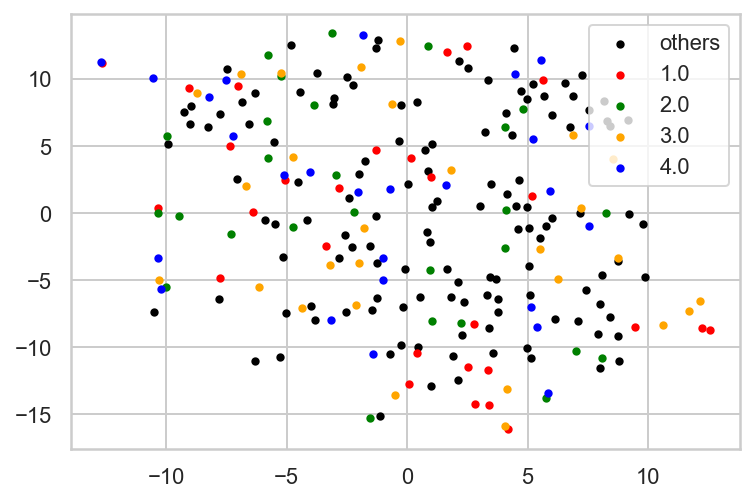

In [248]:
# plot embedded matrix and color points with respect to beat

N = len(df.columns)
beats = ['others','1.0','2.0','3.0','4.0']
labels = np.zeros(N)
for i in range(N):
    if '1.0' in df.columns[i]:
        labels[i] = 1
    if '2.0' in df.columns[i]:
        labels[i] = 2
    if '3.0' in df.columns[i]:
        labels[i] = 3
    if '4.0' in df.columns[i]:
        labels[i] = 4

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

cdict = {0: 'black', 1:'red', 2: 'green', 3:'orange', 4:'blue'}

model = TSNE()
transformed = model.fit_transform(sg.W1)

xs = transformed[:,0]
ys = transformed[:,1]
fig, ax = plt.subplots()
for g in np.unique(labels):
    ix = np.where(labels == g)
    ax.scatter(xs[ix], ys[ix], c = cdict[g], label = beats[int(g)], s = 10)
ax.legend()
plt.show()

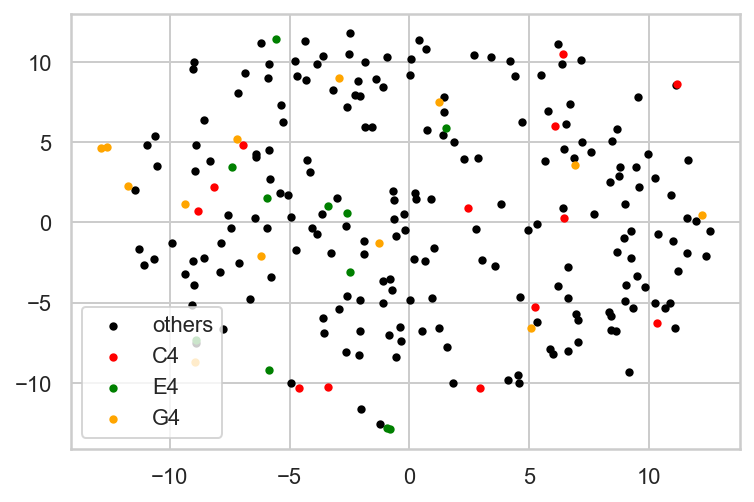

In [246]:
# plot embedded matrix and color points with respect to pitch


labels = np.zeros(N)
tonics = ['others','C4','E4','G4']
for i in range(N):
    if 'C4' in df.columns[i]:
        labels[i] = 1
    if 'E4' in df.columns[i]:
        labels[i] = 2
    if 'G4' in df.columns[i]:
        labels[i] = 3

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

cdict = {0: 'black', 1:'red', 2: 'green', 3:'orange', 4:'blue'}

model = TSNE()
transformed = model.fit_transform(sg.W1)

xs = transformed[:,0]
ys = transformed[:,1]
fig, ax = plt.subplots()
for g in np.unique(labels):
    ix = np.where(labels == g)
    ax.scatter(xs[ix], ys[ix], c = cdict[g], label = tonics[int(g)], s = 10)
ax.legend()
plt.show()